## Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [ ]:
# Please fill in your names here
NAME_STUDENT_1 = ""
NAME_STUDENT_2 = ""

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.

InteractiveShell.ast_node_interactivity = "all" 
HTML('''<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

<style>html, body{overflow: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>

## Support Vector Bananas (4 points (2+2))
We will first explore SVM kernels and hyperparameters on an artificial dataset representing multiple banana shapes. 

In [346]:
from sklearn.model_selection import *
bananas = oml.datasets.get_dataset(1460) # Download banana data
X, y = bananas.get_data(target=bananas.default_target_attribute);
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=1/4)

1 . Evaluate how well an SVM classifier can fit the data. 

- Use a linear, polynomial and radial basis function (RBF) kernel, using their default hyperparameters. Evaluate the performance of each kernel using the test set and AUC. Which one works best? 
- Visualize the results using the visualization code also used in class (under mglearn/plot_svm.py > plot_svm_kernels). Also show the AUC score and the number of support vectors. Explain intuitively how well the data is fitted, why the kernel is (not) able to fit the data, whether it is under- or overfitting, etc.

2 . Pick the RBF kernel and optimize the two most important hyperparameters (the $C$ parameter and the kernel width $\gamma$). 

- First, optimize manually using 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
- Next, optimize the hyperparameters using a grid search and 10-fold cross validation. Show a heatmap of the results snd report the optimal hyperparameter values.
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. Use at least 10 values for each.

## Building Kernels (4 points (0.5+0.5+1+2))

Consider the artificial dataset given below. It represents a sine wave with added noise.

1. Fit an SVM Regressor with the default RBF kernel, and plot the predictions on all data points in [0, 40]. 

    - Does it fit the data well? Does it extrapolate well (in the range [30,40])? Explain your findings. 
    - Can you get better results by tweaking the kernel or the other SVM parameters?
    
2. Implement your own linear kernel. This is a function that takes 2 vectors (arrays) and returns the dot product:

      $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \mathbf{x}_i \cdot \mathbf{x}_j$$
    - Build an SVM regressor using that kernel by passing your kernel function as the `kernel` hyperparameter. 
    - Fit it on the sine data and plot the predictions on all data points. Interpret the results.
    
3. Since this data is periodic, it makes sense to implement a periodic kernel instead. 

    - This is the Exponential Sine Squared kernel, with length scale $\Gamma$ and periodicity $P$:
  $$k(\mathbf{x}_i,\,\mathbf{x}_j) = \exp \left( -\Gamma\,\sin^2\left[\frac{\pi}{P}\,\left|\left|x_i-x_j\right|\right|\right]\right)$$
    - Implement it, using the defaults $\Gamma=1$, periodicity $P=1$, and Euclidean distance.
    - Train an SVM regressor with it, fit in on the same data and plot the result. Interpret the outcome. 
    - Think about what $\Gamma$ and $P$ represent. Can you improve the fit by manually adjusting them? Explain your findings.
    - Optimize $\Gamma$ and periodicity $P$ (using `true_y` as the ground truth). Use a grid search or random search, $\Gamma \in [0,1]$, $P \in [1,100]$, try at least 5 values for each.

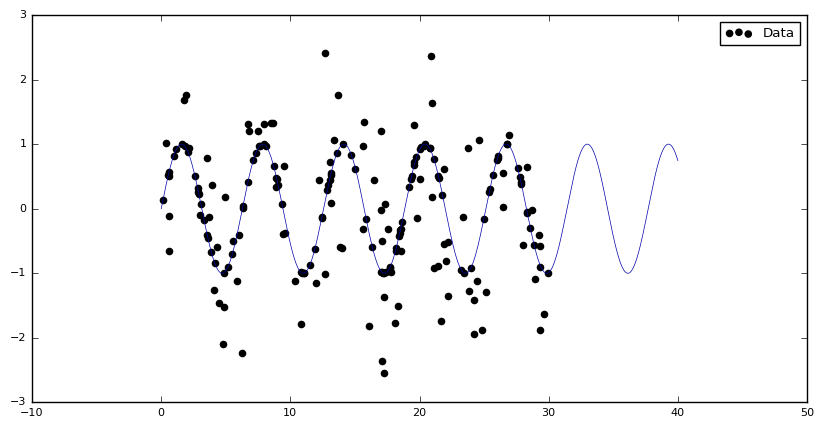

In [3]:
# Generate sample data
rng = np.random.RandomState(0) # Random seed, for reproducibility 
X = 30 * rng.rand(200, 1)
y = np.sin(X).ravel() 
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2) # adds noise

X_plot = np.linspace(0, 40, 10000)[:, None] # A larger range to evaluate on
true_y = np.sin(X_plot) # and the 'true' target function

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.legend()
plt.plot(X_plot, true_y);

In [8]:
print(X.shape)
print(y.shape)
print(X_plot.shape)
print(true_y.shape)

(200, 1)
(200,)
(10000, 1)
(10000, 1)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_plot, true_y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7500, 1)
(2500, 1)
(7500, 1)
(2500, 1)


In [10]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

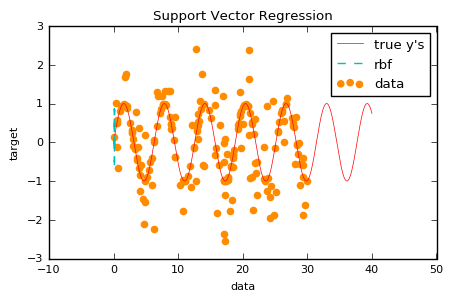

In [11]:
import matplotlib.pyplot as plt

lw = 1
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_plot, true_y, color='red', label='true y\'s');
plt.plot(X_plot[30:40:1], y_pred[30:40:1], color='c', lw=lw, label='rbf')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

This looks pretty bad. The data does not seem to fit in any kind of onto the line. We attempt to tweak parameters gamma and C.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([
    ('svr', SVR(kernel='rbf'))
])

gamma = [0.1, 1, 10, 100, 1000]
c = [0.1, 1, 10 ,100, 1000]
params = [{'svr__gamma': gamma,
           'svr__C': c}]

grid = GridSearchCV(estimator=pipe, param_grid=params)
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'svr__gamma': [0.1, 1, 10, 100, 1000], 'svr__C': [0.1, 1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


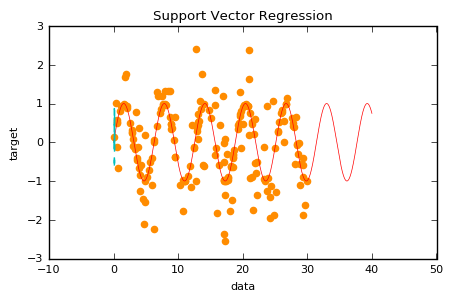

In [21]:
result = grid.best_estimator_.named_steps['svr']
print(result)

y_pred = result.predict(X_test)
lw = 1
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_plot, true_y, color='red', label='true y\'s');
plt.plot(X_plot[30:40:1], y_pred[30:40:1], color='c', lw=lw, label='rbf')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
# plt.legend()
plt.show()

Even though the parameter of the SVM Regressor were optimized using GridSearch the results are visually alike. The first and second plot have same graphs. The rbf kernel may be very unsuited for a sine function.

Building kernels task 2

In [24]:
# our linear kernel
def linear_kernel(vec_a, vec_b):
        return np.dot(vec_a, vec_b.T)

In [25]:
svr_lin = SVR(kernel=linear_kernel)
svr_lin.fit(X_train, y_train)

y_pred_lin = svr_lin.predict(X_test)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel=<function linear_kernel at 0x000001BE2E2A1598>, max_iter=-1,
  shrinking=True, tol=0.001, verbose=False)

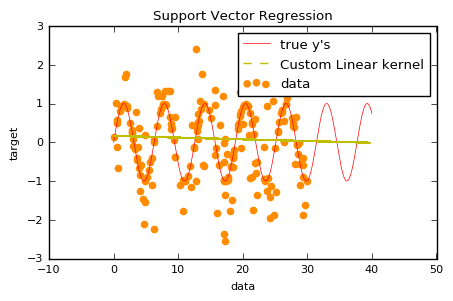

In [30]:
lw = 1
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_plot, true_y, color='red', label='true y\'s');
# plt.plot(X_test, y_pred, color='c', lw=lw, label='rbf')
plt.plot(X_test, y_pred_lin, color='y', lw=lw, label='Custom Linear kernel')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

In the plot above we see the result of the custom linear kernel which calculates the dot product of two vectors. As can be seen the result shows the linear function at the middlepoint of the sine function. This result is not unsurprising since the kernel aims to fit all data points best which would be the midpoint of the sine curve. At the midpoint the linear kernel has on average the best distance to the data points and variance of length will be smallest on average.

Building kernels task 3

In [31]:
from scipy.spatial.distance import cdist

def exponential_sine_squared_kernel(vec_a,vec_b, s=1, p=1):
    """
    :param vec_a: 
    :param vec_b: 
    :param s: scale
    :param p: periodicity
    :return: 
    """
    pi_over_p = np.pi/p
    mag_vec_a_minus_vec_b = cdist(vec_a, vec_b, metric='euclidean')
    sine_ = np.sin(pi_over_p*mag_vec_a_minus_vec_b)
    return np.exp(-s * sine_** 2)


In [40]:
svr_sine = SVR(kernel=exponential_sine_squared_kernel)
svr_sine.fit(X_train, y_train)

y_pred_sine = svr_sine.predict(X_test)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel=<function exponential_sine_squared_kernel at 0x000001BE3445C158>,
  max_iter=-1, shrinking=True, tol=0.001, verbose=False)

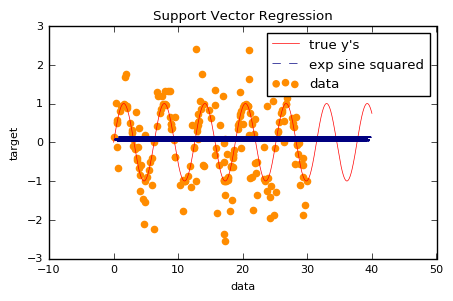

In [54]:
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X_plot, true_y, color='red', label='true y\'s')
plt.plot(X_test, y_pred_sine, color='navy', label='exp sine squared')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
# plt.show()

4 . We now make the problem a bit more challenging by adding an upward trend:

- Fit the same SVM using the optimal parameters from the previous subtask and plot the results. Do they still work? Explain what you see.
- Fit a Gaussian process (GP) using the kernels given below. First use the singular ExpSineSquared kernel (the implementation provided by sklearn this time), then build a new kernel consisting of the 3 components given below. Use both to predict all points for the "rising noisy sine" data and plot the results as usual. Interpret the results.
    - For the GP, it may help to use `normalize_y=True` since the y-values are not around 0. Setting `alpha=0.1` may help with possible numerical issues, otherwise keep it at 0.
- Also plot the _uncertainty interval_ around the predictions. You can ask the GP to return the standard deviation during prediction with the `return_std=True` hyperparameter. Plot a band 2 standard deviations above and below the prediction. You can use MatPlotLib's `fill_between` as shown in class.
    - You can combine the 3 models in one plot for easy comparison.
- We've provided reasonable values for the kernel hyperparameters above. Can you optimize them further to get an even better fit? Think about what the hyperparameters do and optimize the ones you think are most worth tuning.

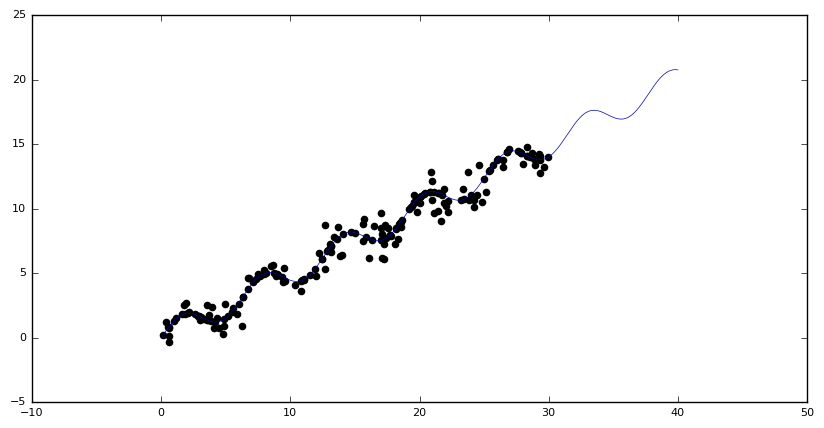

In [3]:
# Generate sample data with added trend
rng = np.random.RandomState(0)
X = 30 * rng.rand(200, 1)
y = X.ravel()/2 + np.sin(X).ravel()
y[::2] += rng.normal(scale = 1.0, size = X.shape[0] // 2)  # add noise

X_plot = np.linspace(0, 40, 10000)[:, None]
true_y = X_plot/2 + np.sin(X_plot)

plt.figure(figsize=(10, 5))
plt.scatter(X, y, c='k', label='Data')
plt.plot(X_plot, true_y);

In [ ]:
import sklearn.gaussian_process.kernels

# Replace `length_scale` and `periodicity` with the values found in the previous part.
kernel_simple = sklearn.gaussian_process.kernels.ExpSineSquared(length_scale=1, periodicity=1) # periodic component

k1 = 4300 * sklearn.gaussian_process.kernels.RBF(length_scale=70.0)  # long term smooth rising trend
k2 = 6 * sklearn.gaussian_process.kernels.RBF(length_scale=90.0) * sklearn.gaussian_process.kernels.ExpSineSquared(length_scale=1.3, periodicity=1.0)  # periodic component
k3 = 0.03 * sklearn.gaussian_process.kernels.RBF(length_scale=0.134) + sklearn.gaussian_process.kernels.WhiteKernel(noise_level=0.035)  # noise terms

## Bayesian updates (3 points (2+1))

We consider real data about solar radiation measured by a weather balloon:
https://www.openml.org/d/512. We'll use only the raw data (at least the first 1000 points) and try to learn the (very noisy) trend. 

1. Train a Gaussian process on an increasing amount of samples of the training data. Use a simple RBF kernel:
`RBF(10, (1e-2, 1e2))`

 - Start with 10 _random_ samples and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Also compute $R^2$ on the training data.
 - Repeat and 10 more points, retrain and redraw. Do this a couple of times and interpret/explain what you see. 
 
2. Train the Gaussian on the full training set.

 - Plot the predictions (including the uncertainty interval) on the full dataset. Evaluate on the test set using $R^2$ 
 - Interpret the results. Is the kernel right? Is the GP under/overfitting?
 - Try to improve the results by tuning the kernel. Do this either manually or using a small grid/random search.

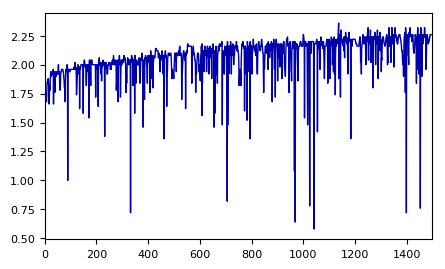

In [91]:
# Get the data
balloon_data = oml.datasets.get_dataset(512) # Download Balloon data
X, y = balloon_data.get_data(target=balloon_data.default_target_attribute);

train = X[:1000]
test = X[1000:1500]
X_train = np.array(list(range(1000)))[np.newaxis].T
y_train = X[:1000].reshape(-1, 1)
X_test = np.array(list(range(1000,1250)))[np.newaxis].T
y_test = X[1000:1500].reshape(-1, 1)
X_all = np.array(list(range(1500)))[np.newaxis].T

pd.Series(X[:1500,0]).plot()

## A data mining challenge (4 points)

The goal here is to use everything you have learned to build the best model for a given classification task. We will use two tasks hosted on OpenML, so you will all receive the same cross-validation splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection, pipeline building, and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial. You need to optimize the AUROC score (calculated using 10-fold cross0-validation).

- Challenge 1: Detects accents in speech data.

    - The OpenML Task ID is 167132: https://www.openml.org/t/167132
    - The dataset description can be found here: https://www.openml.org/d/40910
    - Leaderboard: https://www.openml.org/t/167132#!people
    
- Challenge 2: Image recognition (CIFAR-10 subsample).

    - The OpenML Task ID is 167133: https://www.openml.org/t/167133
    - The dataset description can be found here: https://www.openml.org/d/40926
    - Leaderboard: https://www.openml.org/t/167133#!people
    - Note that this is a high-dimensional dataset (and not so small). Think carefully about how to run experiments in the  time available.
    
- You are able to see the solutions of others (by clicking in the timeline or run list), so you can learn from prior experiments (what seems to work, how long does it take to train certain models, ...). Resubmission of the exact same solution is not possible.
- You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- Document the different experiments that you ran in this notebook (running them can of course be done outside of the notebook). For each experiment, provide a description of how and why you chose the algorithms and parameters that you submitted. Reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows (independently for each task):

    - 1 point for the breadth of experiments you ran (algorithms, pipelines, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Exception: simply repeating top models with nearly identical hyperparameters. This will be checked on the timeline.
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the leaderboard.
        
Note: Report the AUC scores of your best models in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.